# **Assignment 2**
## Contents 
 - I.Introduction

 - II.Task1

 - III.Task2

 - IV.Conclusion

 


## Introdction

Possion problem is a classical PDE problem. Besides calculating the exact solution by mathematical analysis, many people tend to use numerical methods to approximate the exact solution with several iterations. Solving Possion equation with five-point difference format is one of these, which transforms the original problem into a problem of solving a system of linear equations.Then we can use some iterative algorithms like Jacobi, Gauss-Seidel, SOR iteration method, etc to obtain a numerical solution.  

In this assignment, we perform some experiments on possion equation with known boundary. In task1, we implement a function discretises(f,g,N) to solve the possion equation, and manage to anylase the convergence speed of maximum relative error with N increasing. In task2, we try to implement Jacobi iteration method on the GPU, explore maximum relative error convergence against iteration times and the size of N. At last, we also try to optimize the memory accesses in GPU by preloading values into shared memory.

# Task 1

It is known to us, when we have $N^2$ interior points with the five-point difference format, the PDE problem becomes a linear matrix problem $$Ax=f$$ where $x\in R^{N^2}$ collects all the interior values $u_{i,j}$ and $u_{i,j}=x_{jN+i}$. The matrix $A$ is a sparse matrix, with only $5N^2-4N$ nonzon zero elements. Hence, we use the CSR format matrix to store elements in matrix A. CSR format is a kind of sparse matrix data structures, which utilise three arraies to represent a sparse matrix: 
- The data array containing the nonzero entries
- The column indices for the nonzero entries
- Pointers into the column indices to store which indices belong to which row.

With help of CSR format, we can save computer memory and improve computing efficiency, because we only store the information associated to nonzero elements and avoid repetition in the row indices as COO format does in the row indices by pointers into the column indices.

The implementation code is shown there.


Firstly, we define some necessary functions. By importing $u_{exact}\left( x,y \right) =e^{\left( x-0.5 \right) ^2+\left( y-0.5 \right) ^2}$, we can conclude $g(x,y)=e^{\left( x-0.5 \right) ^2+\left( y-0.5 \right) ^2}$, when $x,y=0\ or\ 1$, which is represented as g(x,y) in code, and $f(x,y)=-4e^{\left( \left( x-0.5 \right) ^2+\left( y-0.5 \right) ^2 \right) *\left( 1+\left( x-0.5 \right) ^2+\left( y-0.5 \right) ^2 \right)}$, which is represented as u(x,y) in code.

In [ ]:
#Define necessary functions
#g is origin function, which can be used to calculate the function value of boundary points
#u is f 
from math import exp
import numpy as np
def g(x,y):
  return np.exp((x-0.5)**2+(y-0.5)**2)

def u(x,y):
  return -4*np.exp((x-0.5)**2+(y-0.5)**2)*(1+(x-0.5)**2+(y-0.5)**2)

#define the exact value of u(xi,yj) 
def calculate_u(u_origin,N):
  h=1/(N+1)
  u_exact=np.empty([N,N],dtype=np.float64)
  for j in range(N):
    for i in range(N):
      u_exact[i,j]=u_origin(i*h+h,j*h+h)
  return u_exact


In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
def discretise(f,g,N):
  #we totally have (N+2)^2 discrete points,and N+1 intervals
  #we have N^2 interior points
  grid_dim=N
  h=1/(N+1)#the lenght of interval between 2 discrete points
  nelements=(N+2*(N-1))*N+N*(N-1)*2
  row_ind=np.empty(nelements,dtype=np.float64)
  col_ind=np.empty(nelements,dtype=np.float64)
  data=np.empty(nelements,dtype=np.float64)
  f_dis=np.empty(N*N,dtype=np.float64)
  count=0
  for j in range(N):
    for i in range(N):
      if (i==0) and (j==0):
        #Bottom left case
        f_dis[j*N+i]=f(i*h+h,j*h+h)+((1/h)**2)*(g(i*h+h,j*h)+g(i*h,j*h+h))
        row_ind[count:count+3]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i+1
        col_ind[count+2]=(j+1)*N+i
        data[count]=4*(1/h)**2
        data[count+1:count+3]=-(1/h)**2
        count+=3  

      elif (i==N-1) and (j==0):
        f_dis[j*N+i]=f(i*h+h,j*h+h)+((1/h)**2)*(g(i*h+h,j*h)+g((i+1)*h+h,j*h+h))
        #Bottom right case
        row_ind[count:count+3]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i-1
        col_ind[count+2]=(j+1)*N+i
        data[count]=4*(1/h)**2
        data[count+1:count+3]=-(1/h)**2
        count+=3        

      elif (i==0) and (j==N-1):
        f_dis[j*N+i]=f(i*h+h,j*h+h)+((1/h)**2)*(g(i*h,j*h+h)+g(i*h+h,(j+1)*h+h))
        #Upper left corner 
        row_ind[count:count+3]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i+1
        col_ind[count+2]=(j-1)*N+i
        data[count]=4*(1/h)**2
        data[count+1:count+3]=-(1/h)**2
        count+=3

      elif (i==N-1) and (j==N-1):
        f_dis[j*N+i]=f(i*h+h,j*h+h)+((1/h)**2)*(g((i+1)*h+h,j*h+h)+g(i*h+h,(j+1)*h+h))
        #Upper right corner 
        row_ind[count:count+3]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i-1
        col_ind[count+2]=(j-1)*N+i
        data[count]=4*(1/h)**2
        data[count+1:count+3]=-(1/h)**2
        count+=3

      elif (0<i<N-1)and(j==0):
        f_dis[j*N+i]=f(i*h+h,j*h+h)+((1/h)**2)*g(i*h+h,j*h)
        #bottom
        row_ind[count:count+4]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i-1
        col_ind[count+2]=j*N+i+1
        col_ind[count+3]=(j+1)*N+i
        data[count]=4*(1/h)**2
        data[count+1:count+4]=-(1/h)**2
        count+=4

      elif (0<i<N-1)and(j==N-1):
        f_dis[j*N+i]=f(i*h+h,j*h+h)+((1/h)**2)*g(i*h+h,(j+1)*h+h)
        #upper
        row_ind[count:count+4]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i-1
        col_ind[count+2]=j*N+i+1
        col_ind[count+3]=(j-1)*N+i
        data[count]=4*(1/h)**2
        data[count+1:count+4]=-(1/h)**2
        count+=4

      elif (i==0)and(0<j<N-1):
        f_dis[j*N+i]=f(i*h+h,j*h+h)+((1/h)**2)*g(i*h,j*h+h)
        #left  
        row_ind[count:count+4]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i+1
        col_ind[count+2]=(j-1)*N+i
        col_ind[count+3]=(j+1)*N+i
        data[count]=4*(1/h)**2
        data[count+1:count+4]=-(1/h)**2
        count+=4

      elif (i==N-1)and(0<j<N-1):
        f_dis[j*N+i]=f(i*h+h,j*h+h)+((1/h)**2)*g((i+1)*h+h,j*h+h)
        #right
        row_ind[count:count+4]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i-1
        col_ind[count+2]=(j-1)*N+i
        col_ind[count+3]=(j+1)*N+i
        data[count]=4*(1/h)**2
        data[count+1:count+4]=-(1/h)**2
        count+=4

      else:
        row_ind[count:count+5]=j*N+i
        col_ind[count]=j*N+i
        col_ind[count+1]=j*N+i+1
        col_ind[count+2]=j*N+i-1
        col_ind[count+3]=(j+1)*N+i
        col_ind[count+4]=(j-1)*N+i
        data[count]=4*(1/h)**2# -
        data[count+1:count+5]=-(1/h)**2 #=-1/h^2
        #h=1/N-1,xi=ih,yj=jh
        f_dis[j*N+i]=f(i*h+h,j*h+h)
        count+=5

  return coo_matrix((data,(row_ind,col_ind)),shape=(N**2,N**2)).tocsr(),f_dis

We try to use scipy.sparse.linalg.spolve to solve the sparse linear equations system.

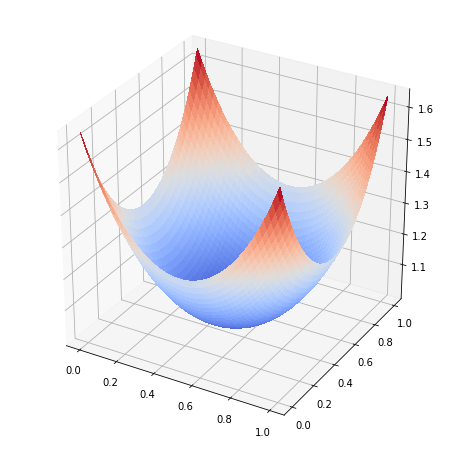

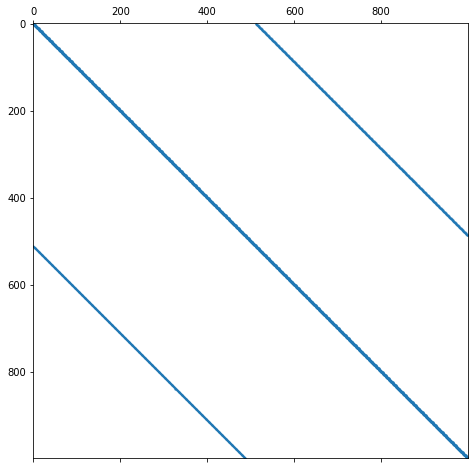

In [ ]:
# plot test
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.sparse.linalg import spsolve
N=512 #interior points dimension:N*N
A,f=discretise(u,g,N)
sol=spsolve(A, f)
sol_reshape=sol.reshape((N, N))
fig=plt.figure(figsize=(8, 8))
ax=fig.gca(projection='3d')
ticks= np.linspace(0, 1, N)
X,Y=np.meshgrid(ticks,ticks)
surf=ax.plot_surface(X, Y, sol_reshape, antialiased=False, cmap=cm.coolwarm)
plt.show()
#----------------------coefficient matrix visualisation----------------------------------#
plt.figure(figsize=(8, 8))
plt.spy(A[:1000, :1000], markersize=1)
plt.show()

From upper picture, we plot the approximate solution result of origin possion problem, which is really similar with $u_{exact}$'s graph, and matrix A only has nonzero elements in the location marked by blue strips.
 

Now we want to evaluate the convergency of this numerical method. 

0.49988204730719543


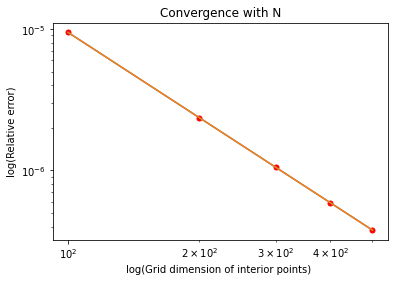

In [ ]:
import numpy as np
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import math
def main():
  N_candidate=[100,200,300,400,500]
  N_test=np.array(N_candidate,dtype=np.int)
  error=np.empty(N_test.shape,dtype=np.float)
  for index,N in list(enumerate(N_test)):
    #print((index,N))
    h=1/(N-1)
    A,f=discretise(u,g,N)
    sol=spsolve(A, f)
    u_numerical=sol.reshape((N, N))
    u_exact=calculate_u(g,N)
    error[index]=np.linalg.norm(u_numerical - calculate_u(g,N), np.inf) / np.linalg.norm(u_numerical, np.inf)
    #print(error[index])
  #plt.plot(N_test,error)
  plt.loglog(N_test,error)
  plt.xlabel('log(Grid dimension of interior points) ')
  plt.ylabel('log(Relative error)')
  plt.title('Convergence with N')
  plt.scatter(N_test,error,s=25,c='r')
  #print('Convergence with N',error)
  
  a=(math.log(N_test[1])-math.log(N_test[-1]))/(math.log(error[-1])-math.log(error[1]))
  print(a)
if __name__=="__main__":
  main()  

The slope of the trend line in the loglog plot is about 0.5, which means 
$$\log \left( relative\_error \right) =-\frac{1}{2}\log \left( N \right) +b$$
$$relative\_error=10^{-\frac{1}{2}\log \left( N \right) +b}=10^bN^{-\frac{1}{2}}$$
It is shown that the relative_error is convergent with N. The rate of convergence for log(relative_error) against log(N) could be 0.5. 

# Task 2

In task2, we utilise the Jacobi iteration method to update the value of every iterior points on GPU. GPU has a certain amount of memory called global memory, where every threads can access. Because GPU can only process data on device, so we need allocate two global buffers in the global memory to carry out interation. 


## 2.1 Iterative solution on GPU

We create a kernel function to perform every iterations

In [ ]:
@cuda.jit
def iteration_once(f,N,x_c,x_n):
  #x_c stores previous iteration result 
  #x_n stores iteration result to be calculated 
  h=1/(N+1)
  px,py=cuda.grid(2)#px,py represent threads' global location
  if 0<px<N+1 and 0<py<N+1:
    x_n[py,px]=0.25*((h**2)*f[py,px]+x_c[py-1,px]+x_c[py+1,px]+x_c[py,px-1]+x_c[py,px+1])

We launch multi-threads on GPU and every threads perform some simple computing in parallel, which has this great advantage compared with CPU serial operation.

In oder to test easily, we wrote a class which contains several variables and methods.We initialize the dimension of TPB to 32. Because in the GPU, 32 threads form a warp, and in a warp, threads can work in parallel. Therefore, when we allocate threads, we hope that the total number of threads allocated is a multiple of 32 as much as possible, thereby increasing the degree of parallelism   

In [ ]:
import numpy as np
import numba
from numba import cuda
import math
from time import time
#--------------------------------------------for plotting--------------------------------#
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

@cuda.jit
def iteration_once(f,N,x_c,x_n):#for once iteration operation
  h=1/(N+1)
  px,py=cuda.grid(2)#
  if 0<px<N+1 and 0<py<N+1:
    x_n[py,px]=0.25*((h**2)*f[py,px]+x_c[py-1,px]+x_c[py+1,px]+x_c[py,px-1]+x_c[py,px+1])
  

class iterator(object):
  def __init__(self,N,blockDimX=32,blockDimY=32):
  #Define some global variables in class
    self.N=N
    self.h=1/(N+1)
    self.TPB=(blockDimX,blockDimY)
  #Allocate memory for necessary arries in CPU, and initialize them
    self.cpu_result=np.zeros((N+2,N+2),dtype=np.float32)
    self.current=np.zeros((N+2,N+2),dtype=np.float32)
    self.f=np.zeros((N+2,N+2),dtype=np.float32)
    
    #initialize current and f
    for i in range(0,N+2):
      for j in range(0,N+2):
        if i==0 or i==N+1 or j==0 or j==N+1:
          self.current[i,j]=g(i*self.h,j*self.h)
        self.f[i,j]=u(i*self.h,j*self.h)
    #initialize 'next'
    self.next=self.current.copy()
  #Grid information
    self.BPG=(math.ceil(self.N/self.TPB[0]),math.ceil(self.N/self.TPB[1]))

  #Push data into GPU global memory 
    self.current_device=cuda.to_device(self.current)
    self.next_device=cuda.to_device(self.next)
    self.f_device=cuda.to_device(self.f)
    
    #gpu_error_result=cuda.to_device(cpu_error_result)
    #gpu_corresponding_u=cuda.to_device(cpu_corresponding_u)

  #-----------------------------------------------------------define some necessary methods-----------------------------------------------#
  
  
  #method for launching iterator for int(iter) times
  def launch_iterator(self,iter):
    for k in range(iter):
      iteration_once[self.BPG,self.TPB](self.f_device,self.N,self.current_device,self.next_device)
      self.current_device,self.next_device=self.next_device,self.current_device
      #cuda.synchronize()
  #method for getting iteration result in GPU and then copy the final result to CPU   
  def iterative_result(self):
    self.current_device.copy_to_host(self.cpu_result) 
    iterior_points_result=self.cpu_result[1:-1,1:-1]
    return iterior_points_result
  
  def test_convergency(self,iter,interval):#iter=60000,interval=100
    benchmark_list=np.array([element for element in range(interval,iter+interval,interval)],dtype=np.float32)
    error_array=benchmark_list.copy()
    error_result=np.ones((self.N+2,self.N+2),dtype=np.float32)
    error_result_device=cuda.to_device(error_result)
    
    result_gpu=cuda.to_device(error_array)
    count=0
    for k in range(iter):
      iteration_once[self.BPG,self.TPB](self.f_device,self.N,self.current_device,self.next_device)
      self.current_device,self.next_device=self.next_device,self.current_device
      cuda.synchronize()
      if k in benchmark_list:
        maximum_relative_change[self.BPG,self.TPB](self.N,self.next_device,self.current_device,error_result_device,result_gpu[count])
        count=count+1
      result_gpu.copy_to_host(error_array)
    return benchmark_list, error_array




## 2.2 Check the convergence based on $u^k$ and $u^{k+1}$

We write a kernel function to calculte maximum relative error between  $u^k$ and $u^{k+1}$

In [ ]:
import numpy as np
import numba
from numba import cuda
@cuda.jit
def maximum_relative_change(N,x_c,x_n,error_result,result):
  px,py=cuda.grid(2)#
  if 0<px<N+1 and 0<py<N+1:
    error_result[py,px]=abs(x_n[py,px]-x_c[py,px])/abs(x_c[py,px])
  cuda.syncthreads()
  if px==0 and py==0:
    result=max(error_result[1:-1,1:-1])
  

We want to test it when iteration time is 5000,10000,15000,20000,25000,30000,35000,40000

Text(0, 0.5, 'maximum relative error')

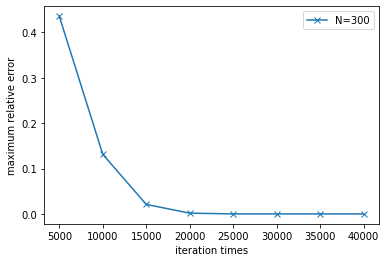

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
k_candidate=[5000,10000,15000,20000,25000,30000,35000,40000]
lines5,=plt.plot(k_candidate,error_array,"x-",label='N=300')
plt.legend(handles=[lines5],labels=['N=300'])
plt.xlabel('iteration times')
plt.ylabel('maximum relative error')


The plot shows that with iteration growing up, the gap between the result of this time and last time is smaller, which hints that Jacobi iterative method is convergent。

## 2.3 The interative results' convergence against the exact solution as N increases

We define some functions to calculte the maximum relative change between every interative result and u_exact. 

In [ ]:
def calculate_relative_error(A,N):
  return np.linalg.norm(A - calculate_u(g,N), np.inf) / np.linalg.norm(calculate_u(g,N), np.inf)

def converge_with_k(N):
  converge_test=[0,0,0,0,0,0,0,0]
  k_candidate=[5000,10000,15000,20000,25000,30000,35000,40000]
  testSolve=iterator(N)#solve a possion problem with 200*200 interior point
  for i in range(len(k_candidate)):
    testSolve.launch_iterator(k_candidate[i])
    result=testSolve.iterative_result()
    converge_test[i]=calculate_relative_error(result,N)
  return converge_test

We compared the iteration results of N = 200, 400, 600, 800 respectively.

Text(0.5, 1.0, 'comparision among difference N')

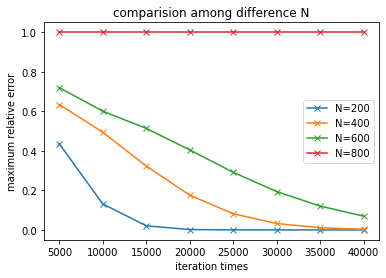

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
l1=converge_with_k(200)
l2=converge_with_k(400)
l3=converge_with_k(600)
l4=converge_with_k(800)
k_candidate=[5000,10000,15000,20000,25000,30000,35000,40000]
lines1,=plt.plot(k_candidate,l1,"x-",label='N=200')
lines2,=plt.plot(k_candidate,l2,"x-",label='N=400')
lines3,=plt.plot(k_candidate,l3,"x-",label='N=600')
lines4,=plt.plot(k_candidate,l4,"x-",label='N=800')
plt.legend(handles=[lines1,lines2,lines3,lines4],labels=['N=200','N=400','N=600','N=800'])
plt.xlabel('iteration times')
plt.ylabel('maximum relative error')
plt.title('comparision among difference N')

We found that for any N, the error decreases as the number of iterations increases. However, when the number of iterations is constant, the larger N is, the greater the error. This shows that the higher the density of meshing, the slower the convergence speed, but the value of its final convergence should be more accurate.

## 2.4 Optimise memory access

Previously, although we have successfully solved the numerical solution of u, when we calculate u(i, j), we have to read data repeatedly from global buffer, which slows down our program. In the GPU architecture, there is a certain amount of shared memory in each block, which can store a small amount of data, but can speed up data reading, further improving the performance of parallel programs.Now,we want to preload data into shared memory to optimise memory access.

Define the kernel function that uses the shared memory

In [ ]:
@cuda.jit
def with_shared_memory(N,f,x_c,x_n):
  h=1/(N+1)
  blocksize=32
  local=cuda.shared.array((34,34),numba.float32)
  tx=cuda.threadIdx.x
  ty=cuda.threadIdx.y
  px,py=cuda.grid(2)
  if px>x_n.shape[0]-2 or px>x_n.shape[0]-2:
    return
  local[tx+1,ty+1]=x_c[px+1,py+1]

  #select ty=1,2,3,4 to store data from four boundries
  if ty==1:
    local[tx+1,0]=x_c[px+1,py]
  elif ty==2:
    local[tx+1,blocksize+1]=x_c[px+1,py+blocksize]
  elif ty==3:
    local[0,tx+1]=x_c[px-tx,py-1+tx]
  elif ty==4:
    local[blocksize+1,tx+1]=x_c[px-tx+blocksize+1,py-2+tx] 
  cuda.syncthreads()
  x_n[tx+1,ty+1]=0.25*((h**2)*f[px,py]+local[tx,ty+1]+local[tx+2,ty+1]+local[tx+1,ty]+local[tx+1,ty+2])
  cuda.syncthreads()   




In [ ]:
class shared_memory(iterator):  
  def launch_iterator(self,iter):
    for k in range(iter):
      with_shared_memory[self.BPG,self.TPB](self.N,self.f,self.current,self.next)
      (self.current,self.next)=(self.next,self.current)
  def timer_for_shared(self):
    timer_test_shared=[0,0,0,0,0,0,0,0]
    k_candidate=[5000,10000,15000,20000,25000,30000,35000,40000]
    test_shared=shared_memory(N)#solve a possion problem with 200*200 interior point
    for i in range(len(k_candidate)):
      test_shared.launch_iterator(k_candidate[i])
      timeit_shared=%timeit -n1 -r3 -o test_shared.launch_iterator(k_candidate[i])
      timer_test_shared[i]=timeit_shared.best
    return timer_test_shared   

We fix iteration times with 1000 times and bechmark for shared memory method and origin method.

Benchmark for shared memory approach

In [ ]:
#benchmark time consuming with shared memory 


test2=iterator(200)
test2.launch_iterator(1000)
%timeit -o test.launch_iterator(1000)

1 loop, best of 5: 1.69 s per loop


<TimeitResult : 1 loop, best of 5: 1.69 s per loop>

Benchmark for global memory approach

In [ ]:
test2=iterator(200)
test2.launch_iterator(1000)
%timeit -o test.launch_iterator(1000)

1 loop, best of 5: 1.65 s per loop


<TimeitResult : 1 loop, best of 5: 1.65 s per loop>

We tested N=200 with 1000 iterations and found that the use of shared memory resulted in a slight improvement in computation speed.

# Conclusion
In real life, there are very few PDEs that can find analytical solutions, so the use of numerical method approximation is in engineering, research field has been widely used. In order to solve the possion equation on the square of units, this paper first explores the relationship between error convergence and grid density, and deduces the relationship between error convergence speed. Secondly, the convergence relationship between grid density N and iteration k is explored by the GPU-accelerated Jacobi iteration method, and we find that the convergence rate is slower with N increases. This may be related to the time-consuming data transfer due to increased computation, while this experiment does not explore the arrangement of block or grid, perhaps when N increases to a certain extent, the optimization of block or grid arrangement can further improve operational efficiency.
At last, we benchmark the shared memory approach and global memory approach(because GPU resources on Colab get to upper limit, I only bencumark one case with N=200,iteration times=1000), we find with shared memory, the computing speed has been accelerated, which means that data in shared memory within a block can be accessed by threads there more quickly.  